In [20]:

import pandas as pd
df = pd.read_csv('/content/judge-1377884607_tweet_product_company.csv', encoding='latin1')
df.head()


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [21]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [22]:
df.isnull().sum()


,0
tweet_text,1
emotion_in_tweet_is_directed_at,5802
is_there_an_emotion_directed_at_a_brand_or_product,0


In [23]:
df = df[['tweet_text', 'is_there_an_emotion_directed_at_a_brand_or_product']]
df.head()

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion


In [24]:
df['is_there_an_emotion_directed_at_a_brand_or_product'] = df['is_there_an_emotion_directed_at_a_brand_or_product'].fillna('No emotion toward brand or product')
df.dropna(subset=['tweet_text'], inplace=True)


In [25]:

import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", '', text)
    text = re.sub(r'@\w+|#', '', text)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

df['clean_text'] = df['tweet_text'].apply(clean_text)
df.head()


,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product,clean_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion,i have a 3g iphone after 3 hrs tweeting at ri...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion,know about awesome ipadiphone app that youl...
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion,can not wait for ipad 2 also they should sale...
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion,i hope this years festival isnt as crashy as ...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion,great stuff on fri sxsw marissa mayer google ...


In [26]:

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['label'] = le.fit_transform(df['is_there_an_emotion_directed_at_a_brand_or_product'])
df.head()


,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product,clean_text,label
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion,i have a 3g iphone after 3 hrs tweeting at ri...,1
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion,know about awesome ipadiphone app that youl...,3
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion,can not wait for ipad 2 also they should sale...,3
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion,i hope this years festival isnt as crashy as ...,1
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion,great stuff on fri sxsw marissa mayer google ...,3


In [27]:
#label counts
df['label'].value_counts()


,count
label,
2,5388
3,2978
1,570
0,156


In [28]:

from sklearn.model_selection import train_test_split

X = df['clean_text'].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

len(X_train), len(X_test)


(7273, 1819)

In [11]:
# tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = 50
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

X_train_pad.shape, X_test_pad.shape


((7273, 50), (1819, 50))

In [12]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=64, input_length=max_len))
model.add(Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(len(le.classes_), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [13]:

history = model.fit(X_train_pad, y_train, validation_split=0.1, epochs=5, batch_size=64, verbose=1)


Epoch 1/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 26s 174ms/step - accuracy: 0.5482 - loss: 1.0862 - val_accuracy: 0.6126 - val_loss: 0.8618
Epoch 2/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 18s 174ms/step - accuracy: 0.6257 - loss: 0.8786 - val_accuracy: 0.6360 - val_loss: 0.8054
Epoch 3/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 0.7331 - loss: 0.7111 - val_accuracy: 0.6635 - val_loss: 0.8106
Epoch 4/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.7884 - loss: 0.5734 - val_accuracy: 0.6813 - val_loss: 0.8650
Epoch 5/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.8313 - loss: 0.4692 - val_accuracy: 0.6607 - val_loss: 0.8938


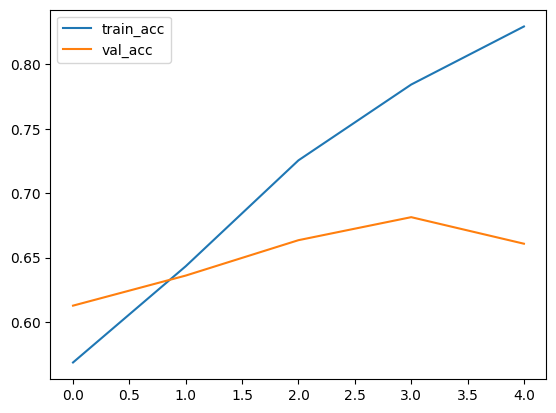

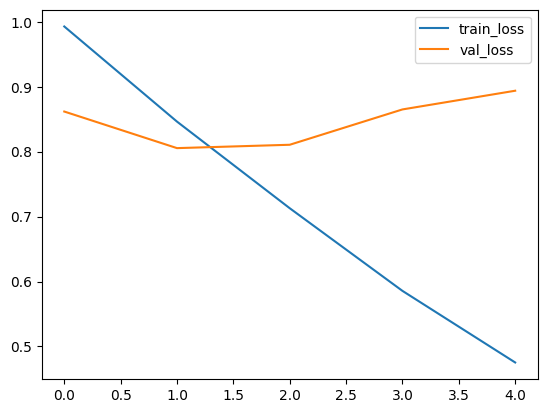

In [14]:
# plot accuracy and loss
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


In [15]:

loss, acc = model.evaluate(X_test_pad, y_test, verbose=0)
print("Test Accuracy:", acc)


Test Accuracy: 0.6547553539276123


In [16]:
# classification report
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred_probs = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_test, y_pred, target_names=le.classes_))


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
                                    precision    recall  f1-score   support

                      I can't tell       0.00      0.00      0.00        31
                  Negative emotion       0.37      0.41      0.39       114
No emotion toward brand or product       0.72      0.78      0.75      1078
                  Positive emotion       0.59      0.51      0.55       596

                          accuracy                           0.65      1819
                         macro avg       0.42      0.43      0.42      1819
                      weighted avg       0.64      0.65      0.65      1819



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[[  0   3  20   8]
 [  0  47  48  19]
 [  0  51 838 189]
 [  0  27 263 306]]


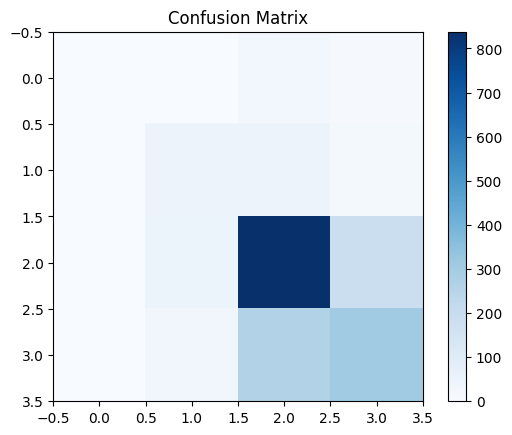

In [17]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.show()


In [30]:
# predictions
for i in range(5):
    print("Tweet:", X_test[i])
    print("True:", le.inverse_transform([y_test[i]])[0])
    print("Pred:", le.inverse_transform([y_pred[i]])[0])
    print("###############")


Tweet: congrats rt  yes gowalla wins best andoid app at the team android choice awards thanks all sxsw
True: Positive emotion
Pred: Positive emotion
###############
Tweet: hey tweeps a web industry party calendar u can put on ur iphone or ical amp keep track of whats goin on at sxsw link
True: Positive emotion
Pred: No emotion toward brand or product
###############
Tweet: omg the line for the ipad2 at austins apple store is long alot of sxsw badges link
True: No emotion toward brand or product
Pred: No emotion toward brand or product
###############
Tweet: spearheading japan disaster relief from sxsw via twitter amp iphone socialgood philanthropy
link
True: No emotion toward brand or product
Pred: No emotion toward brand or product
###############
Tweet: rt  were not launching any products  sxsw were doing plenty else join us 4 h4ckers amp 80s dancing 2day link
True: No emotion toward brand or product
Pred: No emotion toward brand or product
###############
